In [1]:
# %pip install torch pymystem3 matplotlib lgbt

In [1]:
import torch
import torch.nn as nn
import re
from lgbt import lgbt
from pymystem3 import Mystem
import matplotlib.pyplot as plt
from collections import defaultdict
# from collections import Counter

In [2]:
device = torch.device("cpu")
print(f"Using device: {device}")

epochs = 10

Using device: cpu


In [3]:
text = open("The_Fellowship_Of_The_Ring.txt", "r").read()
text = text.replace("\n", " ")
text = re.sub(r'[^a-z@# ]', '', text.lower())
text = re.sub(r'[0-9]', ' ', text)

m = Mystem()
lemmatized = m.lemmatize(text)
text = ''.join(lemmatized)

sentences = text.split('.')
window_size = 2

words = []
for sentence in sentences:
    if len(sentence) >= window_size * 2 + 1:
        clean_sentence = re.sub(r'\W+', ' ', sentence).strip()
        if clean_sentence:
            spl = clean_sentence.split()
            words.append(spl)

word_dict = {}
index = 0
for sentence in words:
    for word in sentence:
        if word not in word_dict:
            word_dict[word] = index
            index += 1

bacov = {v: k for k, v in word_dict.items()}

dataset = []
for sentence in words:
    for i in range(window_size, len(sentence) - window_size):
        target_word = sentence[i]
        context_words = (
            sentence[i - window_size : i] + 
            sentence[i + 1 : i + window_size + 1]
        )
        
        try:
            dataset.append((
                torch.tensor(word_dict[target_word]),
                torch.tensor([word_dict[w] for w in context_words])
            ))
        except KeyError as e:
            print(f"Пропущено слово: {e}")
            continue

total = len(dataset)
train_size = int(0.8 * total)
val_size = int(0.05 * total)

indices = torch.randperm(total)
train = [dataset[i] for i in indices[:train_size]]
validation = [dataset[i] for i in indices[train_size:train_size+val_size]]
test = [dataset[i] for i in indices[train_size+val_size:]]

print(f"Всего примеров: {total}")
print(f"Размеры выборок: Train={len(train)}, Val={len(validation)}, Test={len(test)}")

Всего примеров: 187222
Размеры выборок: Train=149777, Val=9361, Test=28084


In [7]:
def train_model (model, optimizer, criterion, train_data):
    losses = []
    for epoch in range(epochs):
        cnt = 0
        loss_epoch = 0

        train_bar = lgbt(train_data, desc=f'Epoch {epoch+1}', hero = 'kitten')

        for pair in train_bar:
            optimizer.zero_grad()

            # output = model.forward(pair[1].to(device))
            # loss = criterion(output,pair[0].to(device))

            output = model.forward(pair[0].to(device))
            loss = criterion(output,pair[1].to(device))
            
            loss.backward()

            optimizer.step()
            loss_epoch += loss.item()
            cnt += 1

        loss_epoch /= cnt
        losses.append(loss_epoch)
        print(f'Epoch {epoch+1}/{epochs}: Loss train = {loss_epoch}') 
    return losses

In [8]:
def plot_losses (arr):
    plt.figure()
    plt.plot(arr)
    plt.title('Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

In [9]:
def summarize(word1, word2, dict):
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    UK_RF_148 = dict[word1] + dict[word2]
    mindist = 1000000000
    cnt = 0
    for word in dict.keys():
        if cos(dict[word],UK_RF_148) < mindist:
            mindist = cos(dict[word],UK_RF_148)
            mini = word
        cnt+=1
    return mini

In [10]:
def get_closest(vec, dict):
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    mindist = 1000000000
    for word in dict.keys():
        if cos(dict[word],vec) < mindist:
            mindist = cos(dict[word],vec)
            mini = word
    return mini

In [17]:
dataset = []

for sentence in words:
    for i in range(window_size,len(sentence)-window_size):
        target = torch.zeros(len(word_dict))
        target[word_dict[sentence[i]]] = 1
        target = target.type(torch.LongTensor)
        context = []
        for j in range(i-window_size,i+window_size+1):
            if j == i:
                continue
            context.append(word_dict[sentence[j]])
        context = torch.tensor(context)
        dataset.append((target,context))


pivot = int(0.8*len(dataset))
train = dataset[:pivot]
test = dataset[pivot:]

pivot = int(0.05*len(dataset))
validation = test[:pivot]
test = test[pivot:]

In [18]:
class Word2VecCBOWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2VecCBOWModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.out_layer = nn.Linear(embedding_dim, vocab_size)
        self.activation_function = nn.LogSoftmax(dim=0)

    def forward(self, center_word_idx):
        hidden_layer = torch.mean(self.embeddings(center_word_idx), dim=1)
        out_layer = self.out_layer(hidden_layer)
        log_probs = self.activation_function(out_layer)
        return log_probs

In [19]:
w2v_cbow = Word2VecCBOWModel(len(word_dict),window_size*2).to(device)
criterion = nn.NLLLoss().to(device)
optimizer = torch.optim.SGD(w2v_cbow.parameters(), lr=0.001)

In [20]:
loss_arr = train_model (w2v_cbow, optimizer, criterion, train)

🐱Epoch 1     :100% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋[149760/149777] [52.45s, 2855.33it/s]  6it/s]  
Epoch 1/10: Loss train = 0.3452923466375702
🐱Epoch 2     :100% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋[149760/149777] [51.77s, 2892.57it/s]  6it/s]  
Epoch 2/10: Loss train = 0.045304009404466765
🐱Epoch 3     :100% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋[149760/149777] [52.03s, 2878.09it/s]  0it/s]  
Epoch 3/10: Loss train = 0.04288792062595249
🐱Epoch 4     :100% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋[149760/149777] [51.85s, 2888.47it/s]  9it/s]  
Epoch 4/10: Loss train = 0.04124278251411471
🐱Epoch 5     :100% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋[149760/149777] [52.01s, 2879.53it/s]  7it/s]  
Epoch 5/10: Loss train = 0.03976328190282142
🐱Epoch 6     :100% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋[149760/149777] [52.18s, 2870.04it/s]  9it/s]  
Epoch 6/10: Loss train = 0.0383364810

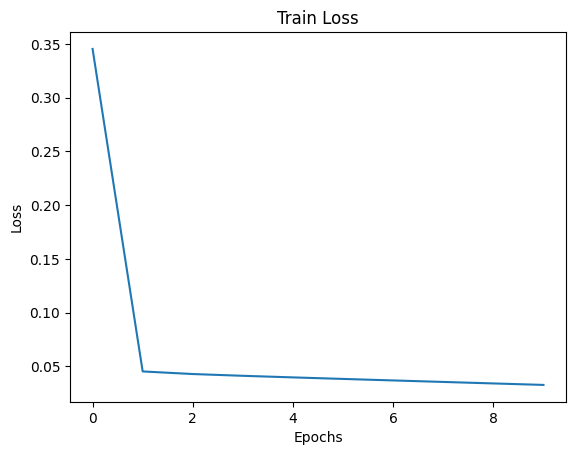

In [21]:
plot_losses (loss_arr)

In [ ]:
torch.save(w2v_cbow, "w2v_cbow.pth")

In [22]:
model = torch.load("w2v_cbow.pth", weights_only=False)

In [23]:
out = model.forward(train[0][1].to(device))

embeddings = model.embeddings.weight.data.cpu()
w2v_dict = {bacov[ix]: embeddings[ix] for ix in range(len(word_dict))}

# w2v_dict.keys()

In [24]:
print (summarize ('beauty', 'change', w2v_dict),
       summarize ('beautiful', 'colour', w2v_dict), 
       summarize ('till', 'never', w2v_dict),
       summarize ('really', 'shines', w2v_dict),
       summarize ('anxiety', 'judge', w2v_dict),
       get_closest (w2v_dict['back'] + w2v_dict['vanish'], w2v_dict),
       sep='\n')

preparing
chaered
inaudible
fled
prying
benevolent


In [17]:
device = torch.device("cuda")
print(f"Using device: {device}")

Using device: cuda


In [12]:
dataset2 = []

for sentence in words:
    for i in range(window_size,len(sentence)-window_size):
        target = torch.tensor(word_dict[sentence[i]])
        context = torch.zeros(len(word_dict))

        for j in range(i-window_size,i+window_size+1):
            if j == i:
                continue
            context[word_dict[sentence[j]]] = 1

        context = context.type(torch.LongTensor)
        dataset2.append((target,context))

pivot = int(0.8*len(dataset2))
train = dataset2[:pivot]
test = dataset2[pivot:]

pivot = int(0.05*len(dataset2))
validation = test[:pivot]
test = test[pivot:]

In [18]:
class Word2VecSkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2VecSkipGramModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.out_layer = nn.Linear(embedding_dim, vocab_size)
        self.activation_function = nn.LogSoftmax(dim=-1)

    def forward(self, center_word_idx):
        hidden_layer = self.embeddings(center_word_idx)
        out_layer = self.out_layer(hidden_layer)
        log_probs = self.activation_function(out_layer)
        return log_probs

In [19]:
w2v_SGM = Word2VecSkipGramModel(len(word_dict),4).cuda()
criterion = nn.NLLLoss().cuda()
optimizer = torch.optim.SGD(w2v_SGM.parameters(), lr=0.05)

In [20]:
loss_arr = train_model (w2v_SGM, optimizer, criterion, train)

🐱Epoch 1     :100% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋[149760/149777] [149.41s, 1002.36it/s]  it/s]  
Epoch 1/10: Loss train = 0.07669831935653529
🐱Epoch 2     :100% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋[149760/149777] [152.29s, 983.37it/s]  it/s]  m
Epoch 2/10: Loss train = 0.06273658491144286
🐱Epoch 3     :100% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋[149760/149777] [154.62s, 968.56it/s]  it/s]  
Epoch 3/10: Loss train = 0.062433078126184836
🐱Epoch 4     :100% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋[149760/149777] [153.13s, 978.00it/s]  it/s]  
Epoch 4/10: Loss train = 0.06215205495562411
🐱Epoch 5     :100% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋[149760/149777] [149.25s, 1003.44it/s]  it/s]  
Epoch 5/10: Loss train = 0.06186827092460371
🐱Epoch 6     :100% ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋[149760/149777] [146.49s, 1022.36it/s]  it/s]  
Epoch 6/10: Loss train = 0.06158887253

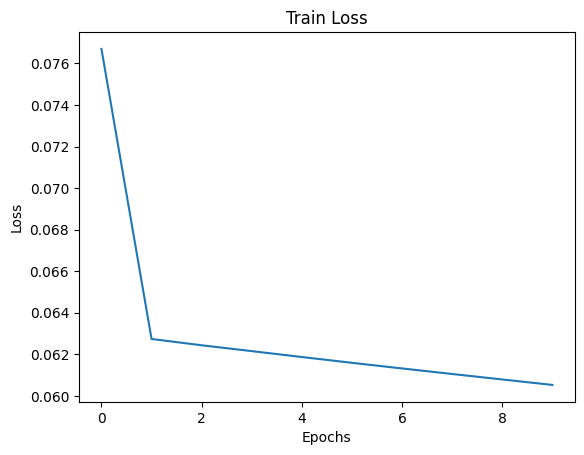

In [21]:
plot_losses (loss_arr)

In [22]:
torch.save(w2v_SGM, "w2v_SGM.pth")

In [27]:
model2 = torch.load("w2v_SGM.pth", weights_only=False)

In [28]:
embeddings2 = model2.embeddings.weight.data.cpu()
w2v_dict2 = {bacov[ix]: embeddings2[ix] for ix in range(len(word_dict))}

# w2v_dict2.keys()

In [29]:
print (summarize ('beauty', 'change', w2v_dict2),
       summarize ('beautiful', 'colour', w2v_dict2), 
       summarize ('till', 'never', w2v_dict2),
       summarize ('really', 'shines', w2v_dict2),
       summarize ('anxiety', 'judge', w2v_dict2),
       get_closest (w2v_dict2['back'] + w2v_dict2['vanish'], w2v_dict2),
       sep='\n')

hollows
becomes
lofty
beggars
tuckborough
pretended
